<h3 align="right">mCP, &nbsp; dSPN, &nbsp; 150602_c1_D1, &nbsp; animal_1_n33_04102017_cel2 </h3>

# Model selection

## Model data

In [21]:
import cell_model, cell_evaluator
morphofile = 'morphology/animal_1_n33_04102017_cel2.swc'
parameters = cell_model.define_parameters('parameters.json')
mechanisms = cell_model.define_mechanisms('mechanisms.json')
protocols = cell_evaluator.define_protocols('protocols.json')
calculator = cell_evaluator.define_fitness_calculator(protocols, 'features.json')
expdata = {
    'IV_354.soma.v': 'expdata/ECall_IV_ch3_354.dat',
    'IV_356.soma.v': 'expdata/ECall_IV_ch3_356.dat',
    'IV_358.soma.v': 'expdata/ECall_IV_ch3_358.dat',
    'IV_360.soma.v': 'expdata/ECall_IV_ch3_360.dat',
    'IV_362.soma.v': 'expdata/ECall_IV_ch3_362.dat',
    'IV_364.soma.v': 'expdata/ECall_IV_ch3_364.dat',    
}

## Simulation environment

In [22]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [23]:
import json
import pandas
import efel
import numpy as np
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

In [24]:
from utils import *

In [25]:
%%capture
!rm -rf x86_64
!nrnivmodl mechanisms

## Cell model definition

In [26]:
morphology = ephys.morphologies.NrnFileMorphology(
    morphofile, do_replace_axon=True)

In [27]:
cell = ephys.models.CellModel(
    'dspn', 
    morph=morphology, 
    mechs=mechanisms, 
    params=parameters)
print (cell)

dspn:
  morphology:
    morphology/animal_1_n33_04102017_cel2.swc
  mechanisms:
    pas.all: pas at ['all']
    kir.somatic: kir at ['somatic']
    kir.basal: kir at ['basal']
  params:
    celsius: celsius = 35
    v_init: v_init = -85.0
    g_pas.axonal: ['axonal'] g_pas = [1e-05, 0.02]
    g_pas.somatic: ['somatic'] g_pas = [1e-05, 0.01]
    g_pas.basal: ['basal'] g_pas = [1e-05, 0.01]
    e_pas.all: ['all'] e_pas = [-80, -60]
    cm.axonal: ['axonal'] cm = 1
    cm.somatic: ['somatic'] cm = 1
    cm.basal: ['basal'] cm = 1
    Ra.all: ['all'] Ra = 150.0
    ek.somatic: ['somatic'] ek = -105.9
    ek.basal: ['basal'] ek = -105.9
    gbar_kir.somatic: ['somatic'] gbar_kir = [0, 0.1]
    shift_kir.somatic: ['somatic'] shift_kir = -20
    q_kir.somatic: ['somatic'] q_kir = 1
    gbar_kir.basal: ['basal'] gbar_kir = [0, 0.01]
    shift_kir.basal: ['basal'] shift_kir = -20
    q_kir.basal: ['basal'] q_kir = 1



In [28]:
opt_params = [p.name for p in cell.params.values() if not p.frozen]
opt_bounds = [p.bounds for p in cell.params.values() if not p.frozen]
for x in sorted(opt_params): print (x)

e_pas.all
g_pas.axonal
g_pas.basal
g_pas.somatic
gbar_kir.basal
gbar_kir.somatic


## Cell evaluator

In [29]:
simulator = ephys.simulators.NrnSimulator()

In [30]:
evaluator = ephys.evaluators.CellEvaluator(
    cell_model=cell,
    param_names=opt_params,
    fitness_protocols=protocols,
    fitness_calculator=calculator,
    sim=simulator)

## Optimisation results

In [31]:
with open('log.json') as fp:
    log = json.load(fp)

<IPython.core.display.Javascript object>


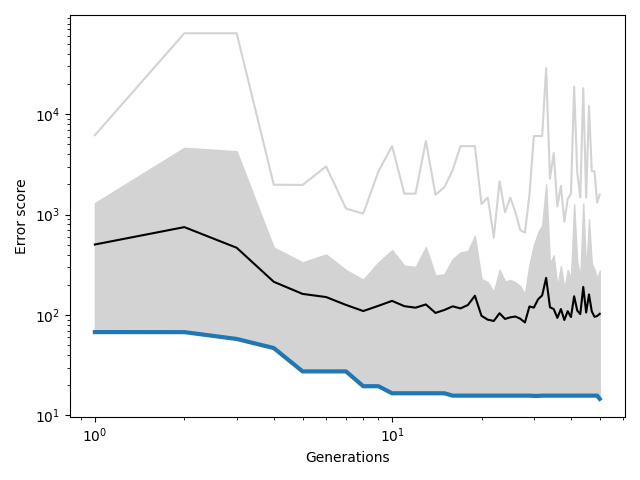

In [32]:
plot_log(log)

In [33]:
best_models = json.load(open('best_models.json'))
pandas.options.display.float_format = '{:,.4g}'.format
bm = pandas.DataFrame(best_models)
bm.T

,0,1,2,3,4,5,6,7,8,9
g_pas.axonal,2.495e-05,0.004938,0.004938,0.007385,0.004938,0.005102,0.005348,0.01285,0.005644,0.006087
g_pas.somatic,0.0008206,0.0007835,0.0007946,0.0008027,0.0007946,0.00116,0.0007624,0.0008302,0.0008006,0.0007946
g_pas.basal,0.0008079,0.0008108,0.0008108,0.0008108,0.0008108,0.0007657,0.0008108,0.0008108,0.0008107,0.0008108
e_pas.all,-67.66,-64.95,-64.94,-64.94,-64.94,-64.94,-64.94,-64.94,-64.94,-64.94
gbar_kir.somatic,0.01785,0.01579,0.01581,0.01602,0.01553,0.01588,0.01581,0.01581,0.01581,0.01581
gbar_kir.basal,0.001605,0.002779,0.002779,0.002779,0.002779,0.002774,0.002779,0.002865,0.002749,0.002747


<IPython.core.display.Javascript object>


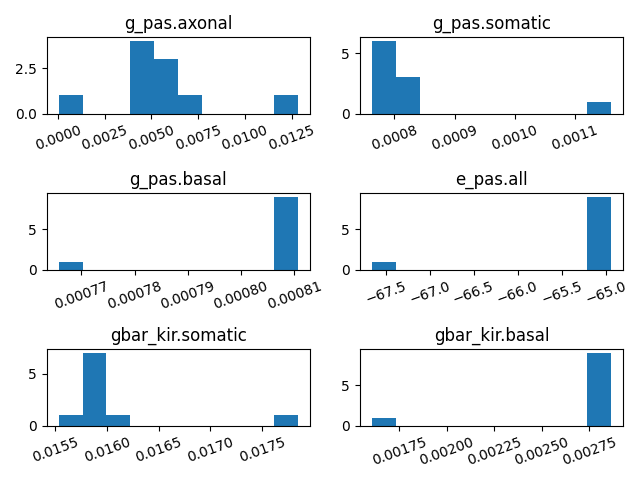

In [34]:
axs = bm.hist(grid=False, xrot=20)
plt.tight_layout();

<IPython.core.display.Javascript object>


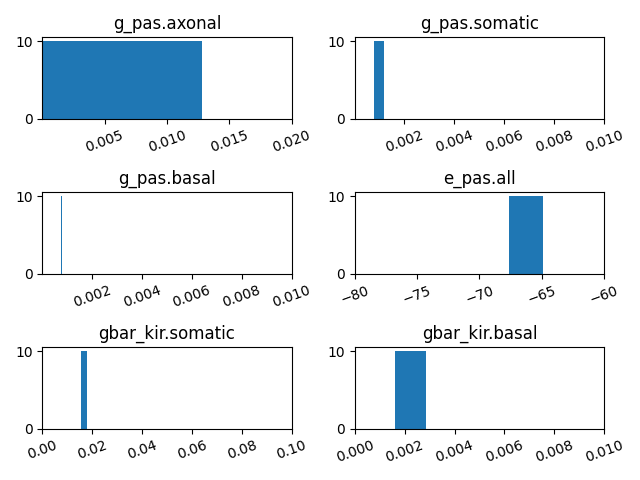

In [35]:
axs = bm.hist(bins=1, grid=False, xrot=20)
for ax, bounds in zip(axs.flatten(), opt_bounds):
        ax.set_xlim(bounds)
plt.tight_layout();

In [36]:
evaluate_all = True
best_objectives = []
if evaluate_all:
    for params in best_models:
        objectives = evaluator.evaluate_with_dicts(params)
        best_objectives.append(objectives)
    df = pandas.DataFrame(best_objectives).T
    df = df.sort_index(axis=0, ascending=False)

<IPython.core.display.Javascript object>


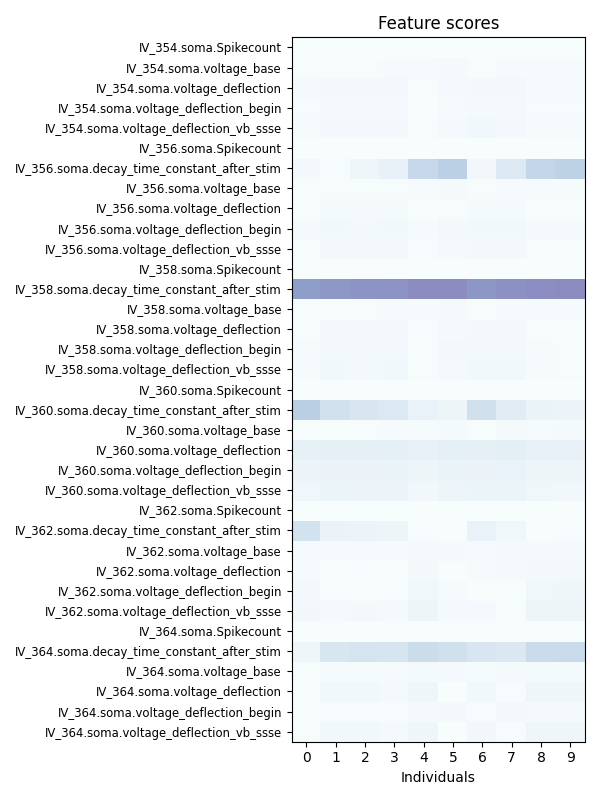

In [37]:
if evaluate_all:
    plot_scores(df, figsize=(6, 8), vmin=0, vmax=10)

## Single-cell simulation

In [38]:
ind = 0
test_parameters = best_models[ind]

In [39]:
test_responses = evaluator.run_protocols(
    protocols=protocols.values(), 
    param_values=test_parameters)

<IPython.core.display.Javascript object>


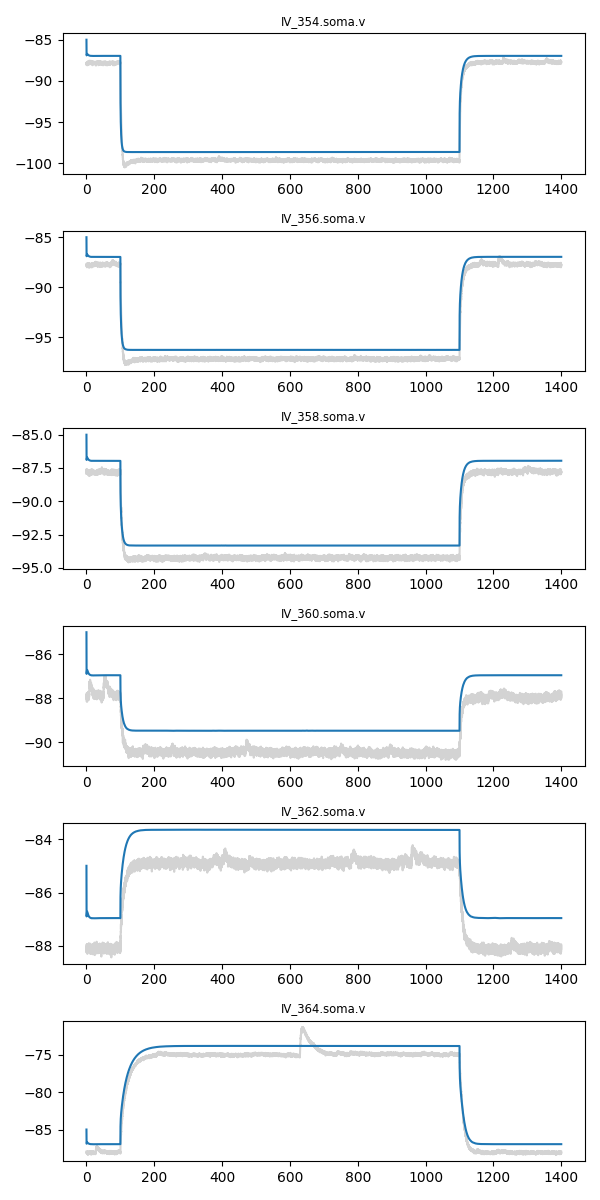

In [40]:
plot_responses(test_responses, expdata=expdata, junction_potential=11.5, figsize=(6,12))

<IPython.core.display.Javascript object>


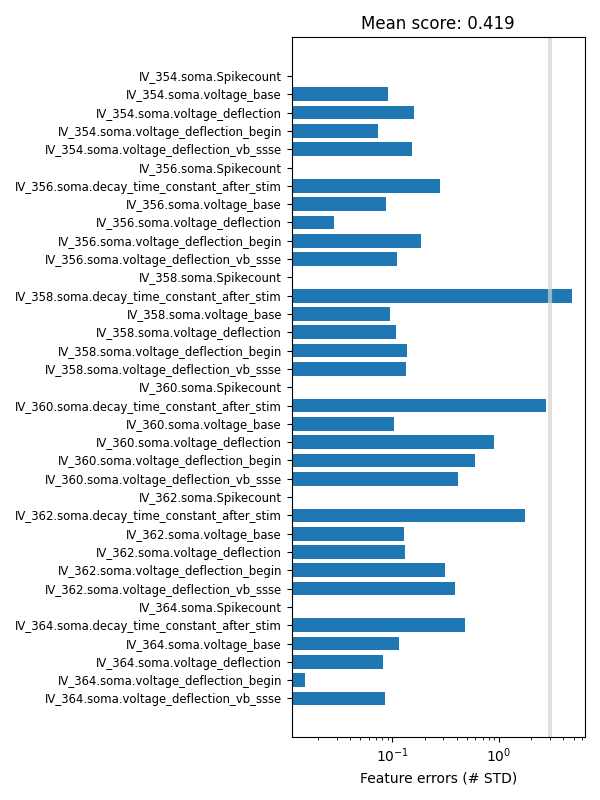

In [41]:
if evaluate_all:
    objectives = best_objectives[ind]
else:
    objectives = evaluator.evaluate_with_dicts(test_parameters)
plot_objectives(objectives, figsize=(6,8))

In [42]:
from numpy.linalg import norm
d = []
for i in range(len(best_models)):
    v = []
    for j in range(len(best_models)):
        p1 = np.array([best_models[i][p] for p in sorted(best_models[i])])
        p2 = np.array([best_models[j][p] for p in sorted(best_models[j])])
        v.append(norm((p1-p2)/(p1+p2)))
    d.append(v)
df = pandas.DataFrame(data=np.round(d,2))
def highlight_low(x):
    def c(v):
        r = int(v/x.max()*255)
        g = int(v/x.max()*128)+127
        b = 255
        return '#%02x%02x%02x' % (r, g, b)
    return ['background-color: %s' % c(v) for v in x]
df.style.apply(highlight_low)

,0,1,2,3,4,5,6,7,8,9
0,0.000000,1.030000,1.030000,1.030000,1.030000,1.040000,1.030000,1.040000,1.030000,1.030000
1,1.030000,0.000000,0.010000,0.200000,0.010000,0.200000,0.040000,0.450000,0.070000,0.100000
2,1.030000,0.010000,0.000000,0.200000,0.010000,0.190000,0.040000,0.450000,0.070000,0.100000
3,1.030000,0.200000,0.200000,0.000000,0.200000,0.260000,0.160000,0.270000,0.130000,0.100000
4,1.030000,0.010000,0.010000,0.200000,0.000000,0.190000,0.050000,0.450000,0.070000,0.100000
5,1.040000,0.200000,0.190000,0.260000,0.190000,0.000000,0.210000,0.460000,0.190000,0.210000
6,1.030000,0.040000,0.040000,0.160000,0.050000,0.210000,0.000000,0.410000,0.040000,0.070000
7,1.040000,0.450000,0.450000,0.270000,0.450000,0.460000,0.410000,0.000000,0.390000,0.360000
8,1.030000,0.070000,0.070000,0.130000,0.070000,0.190000,0.040000,0.390000,0.000000,0.040000
9,1.030000,0.100000,0.100000,0.100000,0.100000,0.210000,0.070000,0.360000,0.040000,0.000000


In [43]:
hall_of_fame = []
selected = range(10)
for model in selected:
    hall_of_fame.append(best_models[model])
with open('hall_of_fame.json', 'w') as fp:
    json.dump(hall_of_fame, fp, indent=4, sort_keys=True)

In [44]:
e_pas = np.mean([x['e_pas.all'] for x in best_models])
#Ra = np.mean([x['Ra.all'] for x in best_models])
#shift_kir = np.mean([x['shift_kir.somatic'] for x in best_models] + [x['shift_kir.basal'] for x in best_models])

In [45]:
print(f'{e_pas=}')

e_pas=-65.21042499479482


In [46]:
best_models[0]['e_pas.all'] #, best_models[0]['shift_kir.somatic']

-67.65721857173715